# Transit of evolved star TIC 441462736

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import astropy.units as u
from glob import glob

paths = glob('441462736/hlsp_*.fits')

files = [fits.getdata(path) for path in paths]

headers = [fits.getheader(path) for path in paths]

In [2]:
from scipy.stats import binned_statistic
from toolkit import LightCurve

In [3]:
lcs = [LightCurve(times=f['TIME'][~np.isnan(f["TIME"]) & ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  fluxes=f['PDCSAP_FLUX'][~np.isnan(f["TIME"])& ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  name=header['OBJECT']) for f, header in zip(files, headers)]

from gravdark import concatenate_light_curves

lc = concatenate_light_curves(lcs)

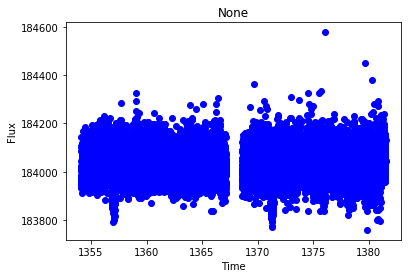

In [4]:
lc.plot()

In [13]:
from robin import TransitParams, TransitModel

paramsb = TransitParams()
paramsb.per = 14.27900
paramsb.t0 = 1357.0131
paramsb.duration = 10/24
paramsb.p0 = 0.0304
paramsb.p1 = 0.0304
paramsb.a = 6.66
paramsb.u = [0.6, 0.2]
paramsb.inc = np.degrees(np.arccos(0.87/paramsb.a))
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.ecc = 0

In [14]:
transitsb = LightCurve(**lc.mask_out_of_transit(paramsb, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsb)

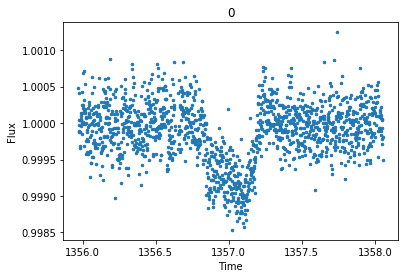

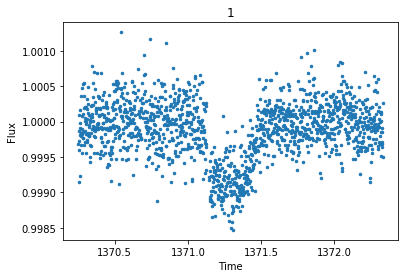

In [25]:
for transit in transitsb: 
    transit.remove_linear_baseline(paramsb)
    
    transit.plot(plot_kwargs=dict(marker='.', lw=0, ms=5))

In [16]:
transits = concatenate_light_curves(transitsb)

In [26]:
from copy import deepcopy
import emcee

def lnlike(p):
    p0, p1, inc, a, t0, per, u1, u2 = p
    
    if p0 < 0 or p0 > 1 or p1 < 0 or p1 > 1 or inc > 90 or a < 1 or per < 1 or u1 > 1 or u1 < -1 or u2 > 1 or u2 < -2:
        return -np.inf
    
    params = deepcopy(paramsb)
    params.per = per
    params.p0 = p0
    params.p1 = p1
    params.t0 = t0
    params.inc = inc
    params.a = a
    params.u = [u1, u2]
    
    m = TransitModel(params, transits.times.jd, exp_time=2/60/24, supersample_factor=3)
    model_fluxes = m.light_curve(params)
    
    yerr = 0.0002 #np.std(transits.fluxes - model_fluxes)
    
    return -0.5 * np.sum( (transits.fluxes - model_fluxes)**2 / yerr**2)

ndim, nwalkers = 8, 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)
initp = [np.array([paramsb.p0, paramsb.p0, paramsb.inc, paramsb.a, 
                   paramsb.t0, paramsb.per, paramsb.u[0], paramsb.u[1]]) 
         + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]

params0 = sampler.run_mcmc(initp, 10000)[0]
sampler.reset()
sampler.run_mcmc(params0, 10000);

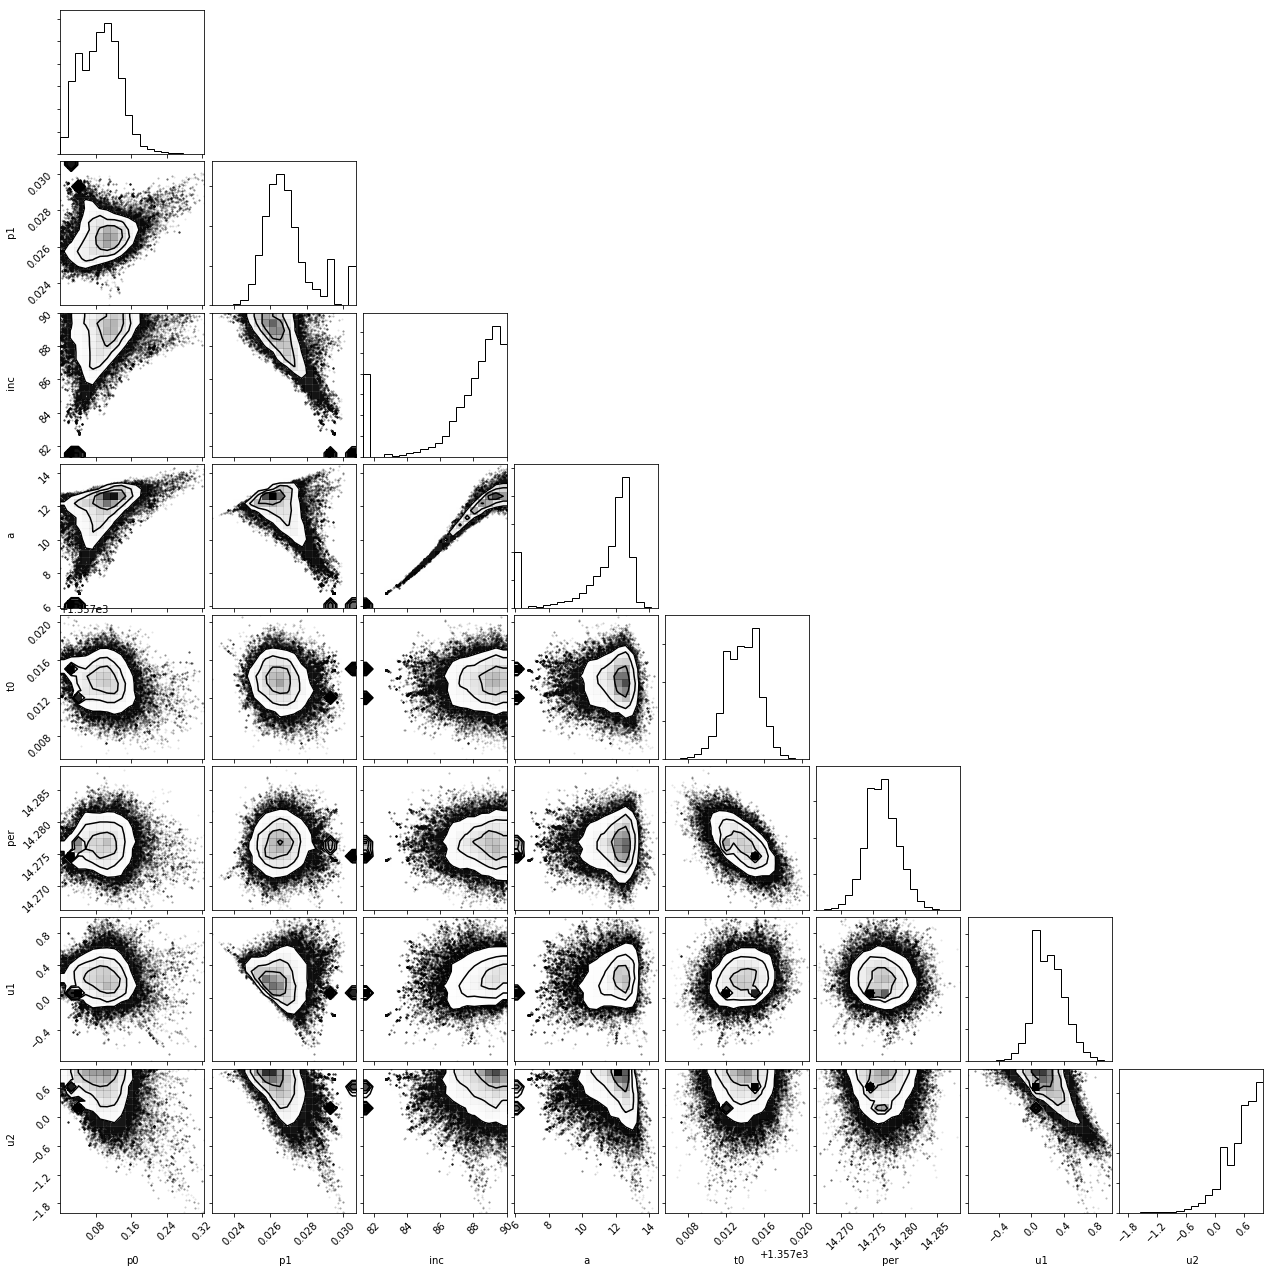

In [27]:
from corner import corner

corner(sampler.flatchain, labels="p0, p1, inc, a, t0, per, u1, u2".split(','));

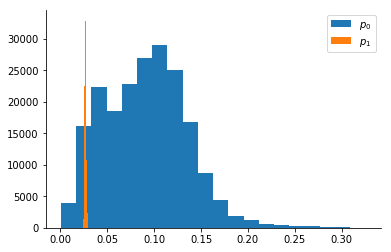

In [28]:
plt.hist(sampler.flatchain[:, 0], bins=20, histtype='stepfilled', label='$p_0$')
plt.hist(sampler.flatchain[:, 1], bins=20, histtype='stepfilled', label='$p_1$')
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)

plt.legend()